In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import choice
from SNARS import Snars
from time import sleep
import re
import json

## P8.1
Prepare a code which draw for given network plot of the relation $C(k)$ [20%]

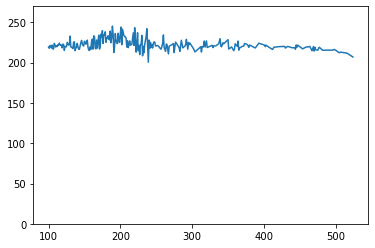

In [2]:
G = nx.generators.barabasi_albert_graph(1000, 100)
def plot_clustering_coeficient(G):
    def avg_degree(G: nx.Graph, k: int) -> float:
        dg =  dict(G.degree)
        k_nodes = [n for n, v in dg.items() if v==k] 
        averages = list(sum(dg[i] for i in G.neighbors(node))/k
                for node in k_nodes) ## list of Average degree of the nearest node for each node of degree k 
        return np.mean(averages)
    X = np.unique(list(dict(G.degree).values()))
    Y = list(map(lambda x: avg_degree(G, x), X))
    plt.plot(X, Y)
    plt.ylim(0, max(Y)*1.1)
plot_clustering_coeficient(G)

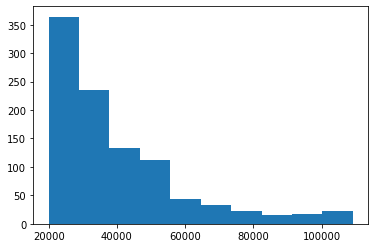

In [3]:
def plot_clustering_coeficient_hist(G):
    def avg_degree(G: nx.Graph, i: int) -> float:
        dg =  dict(G.degree)
        return sum(dg[n] for n in G.neighbors(i))## list of Average degree of the nearest node for each node of degree k 
    Y = list(map(lambda i: avg_degree(G, i), G.nodes))
    plt.hist(Y)
plot_clustering_coeficient_hist(G)

## P8.2
Find examples of hierarchical and non-hierarchical networks inavailable repositories, check by drawing graphs from the taskP8.1. [10%]

## P8.3
Load (perhaps a sub-) set of stops from the data provided byZTM Warszawa on the websitewww.ztm.waw.pl/pliki-do-pobrania/dane-rozkladowe/. Draw graphsbased on this set of vertices associated with the various typesof mass transport. [50%]

In [2]:
routes = json.load(open("routes_week.json", 'r'))
points = json.load(open("points.json", 'r'))
points = {k: (v['lon'], v['lat']) for k, v in points.items()}
edge_list=[]
for k,v in routes.items():
    for end in v.keys():
        edge_list+=[(k, end)]
G = nx.from_edgelist(edge_list)

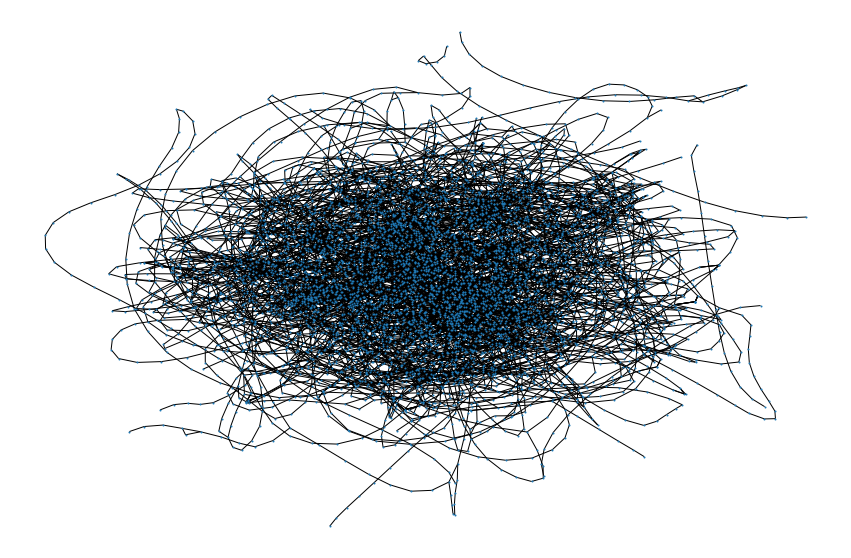

In [11]:
fig, ax = plt.subplots(figsize=(15,10))
nx.draw_spring(G, node_size =1, ax=ax )

## P8.4
Calculate the basic characteristics of each layer, and the wholenetwork. [20%]

## P8.5

Translate GPS coordinates to configuration of the vertices anddraw graph in proper, geographic, configuration. [30%]

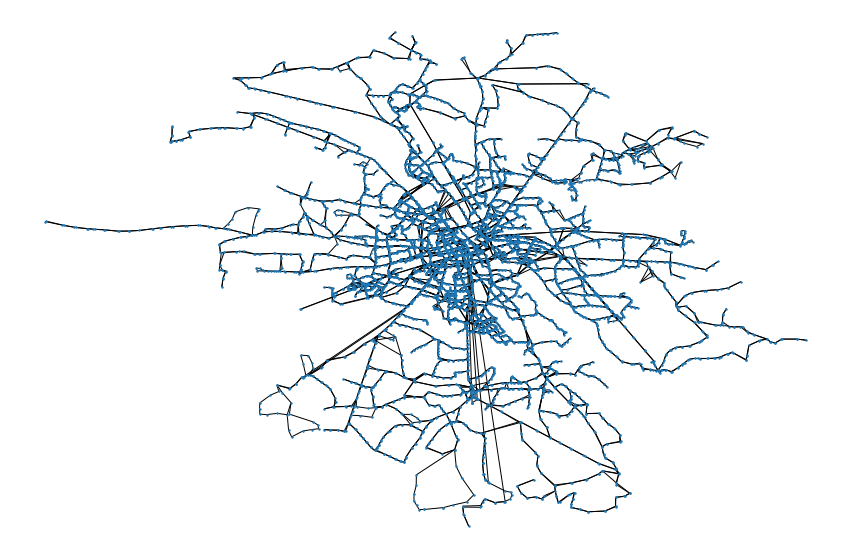

In [5]:
fig, ax = plt.subplots(figsize=(15,10))
nx.draw(G, pos=points, node_size =2, ax=ax)

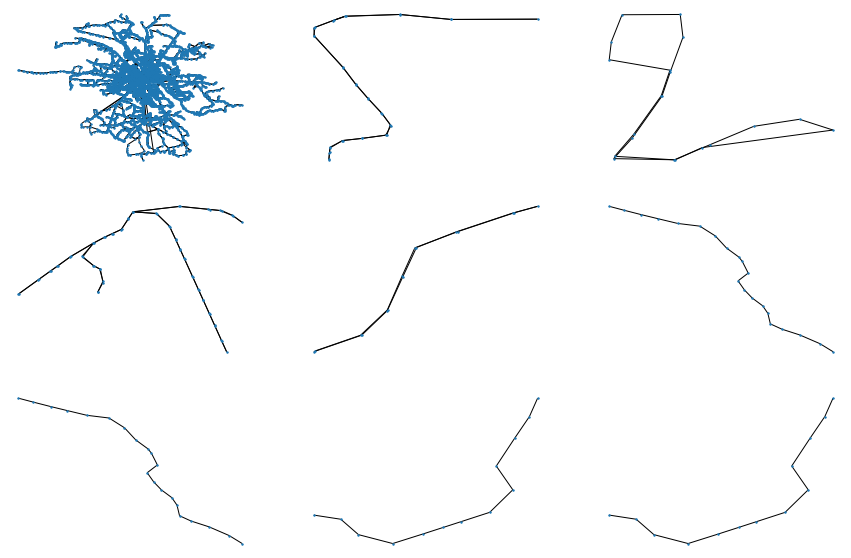

In [6]:
fig, ax = plt.subplots(3, 3, figsize=(15,10))
for i, v in enumerate(nx.connected_components(G)):
    g = nx.subgraph(G, v)
    nx.draw(g, pos=points, node_size =2, ax=ax[i//3, i%3])

## P8.9
Working in groups, let’s ask ourselves a simple researchquestion about the ZTM network and try to answer it! [50%]

In [7]:
points_time = json.load(open("points.json", 'r'))
start = "100101"
def get_route_limited_time(node, time_left):
    result = set()
    time[node]['routes'].items():
        if time<= time_left:
            result.add(point)
        if time<time_left and time>0:
            result = result.union(get_route_limited_time(point, time_left-time))
    return result
time_limited_area = {k: get_route_limited_time(start, k) for k in range(20)}

KeyboardInterrupt: 

In [4]:
times = {0: {'313204'}}
points_time = json.load(open("points.json", 'r'))
def get_near(node):
    result=set()
    lat, lon = points_time[node]['lat'], points_time[node]['lon']
    for k, v in points_time.items():
        if (lat - v['lat'])**2 + (lon - v['lon'])**2 <=0.005**2:
            result.add(k)  
    for k, v in points_time[node]["routes"].items():
        if v<=2:
            result.add(k)
    return result 
        
    
for i in range(1, 30):          
    times[i] = times[i-1].union(set([k for node in times[i-1] for k in get_near(node)]))
    print(times[i])

{'313101', 'M1M004', '313604', '313606', '313202', '313203', '312003', '313104', '329302', '329301', '313204', 'M1K018', '313605', '313201'}
{'313101', '312008', '313203', '313303', '330102', '312702', '313204', '313302', 'M1K017', '312007', '313701', '313606', '313202', '329302', '313404', '313603', '312002', '329301', '312005', '312701', 'M1M005', '312703', 'M1K018', '330101', '313102', '313702', '312004', '312006', '313605', '313401', '313601', 'M1M004', '313602', '312001', '313201', '312003', '313104', '313301', '312704', '313604'}
{'313101', '313303', '329901', '330102', '312702', '313204', '313402', '312007', '329801', '329302', '313404', '312002', '312005', '312703', '312802', '313403', '313102', '329903', '312101', '342002', '312006', '313601', '313602', '342001', '312003', '313301', '312704', '329301', '313201', '312008', '329902', '313203', '313904', '329802', '313302', '312104', 'M1K017', '313701', '313606', '313202', '313603', '329904', '312102', '312701', 'M1M005', 'M1K018

{'313101', '314304', '319002', '301106', '320203', '328102', '300905', '329801', '328104', '314206', '312002', '300911', '312802', '301401', '327903', '314603', '345402', '310201', '320702', '345401', '314222', '312006', '313601', '327901', '301107', '313301', '300916', '329201', '320004', '341602', '328101', '320201', '311002', 'M1K016', '303702', '301102', '320602', '300703', '314601', '314203', 'M1K017', '309601', '328001', '313606', '313805', '300902', '320802', '340302', '312202', '301502', '309803', '315102', '313401', 'M1M004', '301301', '300708', '300918', '345602', '313604', '309602', '329204', '312702', '300904', '313402', '312204', '300906', '301302', '329302', '312005', '309802', '303904', '312703', '301501', '328003', '320202', '300704', '300702', '309801', '314402', '300917', '314302', '312902', '313002', '313602', '312301', '319401', '309805', '311001', '314208', '302902', '313803', 'M1M003', '344301', '312704', '313201', 'M1K020', '315104', '341501', '329101', '310001',

{'313101', '300501', '314304', '340001', '301106', '300905', '329801', '312002', '310201', '303304', '311404', '320702', '345401', '314222', '312006', '323202', '323301', '320301', '323103', '320004', '300916', '329201', '309302', '328101', '320201', '300703', '314601', '324801', '328001', '313606', '313805', '320901', '320304', '343302', '309301', '320802', '328402', '301502', '309803', '315102', '313401', '311501', '301301', '300708', '300918', '345602', '313604', '320101', '311602', '312702', '301302', '329302', '312005', '309802', '301501', '300704', '311504', '311502', '311603', '309801', '300917', '312902', '310401', '311201', '300601', '313602', '319401', '340002', '309805', '311001', '314208', '302902', '313803', 'M1M003', '344301', '312704', 'M1K020', '300402', '324802', '341501', '310001', '330902', '301402', '300605', '313701', '340003', '300914', '300804', '330002', '340004', '311304', '314401', '323104', 'M1M002', '312004', '340006', '313605', '328201', '333801', '314002',

{'313101', '300501', '324005', '314304', '340001', '324304', '324205', '301106', '312602', '323803', '300905', '329801', '312002', '300304', '323902', '303201', '310201', '303304', '311404', '320702', '345401', '314222', '312006', '323202', '304101', '303004', '323301', '320301', '323103', '320004', '300916', '329201', '323801', '309302', '328101', '320201', '300703', '314601', '324801', '328001', '313606', '303303', '324601', '323904', '313805', '320901', '320304', '300306', '343302', '324901', '309301', '324903', '320802', '325004', '328402', '301502', '309803', '310501', '315102', '313401', '311501', '303502', '301301', '300708', '322902', '300105', '300918', '345602', '300104', '313604', '324701', '320101', '311602', '323001', '312702', '312502', '300206', '301302', '329302', '324010', '324201', '312005', '309802', '301501', '300704', '311504', '311502', '311603', '309801', '323905', '300917', '312902', '310401', '311201', '310602', '300601', '313602', '319401', '340002', '324206',

{'313101', '300501', '700902', '324005', '314304', '340001', '324304', '324205', '325104', '301106', '312602', '342501', '323803', '300905', '329801', '312002', '300304', '323902', '303201', '310201', '303304', '311404', '320702', '345401', '314222', '312006', '323202', '304101', '303005', '303004', '323301', '306201', '320301', '323103', '320004', '300916', '329201', '323801', '309302', '328101', '323701', '326702', '320201', '328601', '703802', '300703', '323802', '314601', '324801', '328001', '303303', '313606', '700604', '324601', '323904', '313805', '320901', '320304', '328602', '300306', '343302', '324901', '309301', '414701', '324903', '320802', '325004', '328402', '301502', '304201', '700612', '309803', '306001', '310501', '315102', '313401', '311501', '303502', '332601', '301301', '300708', '322902', '300105', '700605', '300918', '332501', '345602', '300104', '304302', '313604', '311802', '324701', '320101', '703501', '311602', '323001', '311801', '312702', '326902', '308901',

{'300501', '700902', '340001', '324304', '324205', '305902', '301106', '312602', '300905', '329801', '305904', '300304', '323902', '303201', '310201', '320702', '312006', '323202', '703901', '304101', '303005', '320301', '323103', '320004', '329201', '703304', '328101', '320201', '300703', '328001', '303303', '313805', '320304', '324901', '309301', '320802', '304201', '700612', '306001', '303502', '332601', '300708', '322902', '700605', '300918', '304302', '313604', '324701', '701305', '709307', '323001', '311801', '312502', '411101', '415301', '301302', '704002', '301501', '709302', '338302', '311603', '309801', '325102', '323905', '310401', '310602', '403601', '335402', '324206', '305804', '314208', '302902', '700401', '324802', '703401', '325701', '313701', '300914', '703803', '305905', '300804', '330002', '340004', '323702', '314401', '342302', '303002', '312004', 'M1K012', '701102', '328204', '310601', '491802', '303802', '703303', '311202', '313902', '325412', '306203', '701103',

{'300501', '700902', '340001', '324304', '324205', '305902', '301106', '312602', '300905', '403704', '329801', '305904', '300304', '323902', '303201', '310201', '704303', '320702', '703202', '312006', '323202', '703901', '304101', '303005', '320301', '323103', '706803', '320004', '329201', '703304', '411302', '328101', '320201', '403001', '300703', '328001', '303303', '701406', '313805', '320304', '324901', '309301', '706804', '320802', '700102', '304201', '700612', '306001', '303502', '332601', '300708', '322902', '700605', '300918', '304302', '701402', '313604', '324701', '701305', '709307', '323001', '311801', '312502', '706601', '411101', '415301', '301302', '704002', '701304', '301501', '403701', '370602', '709302', '338302', '311603', '309801', '325102', '323905', '310401', '310602', '403601', '335402', '324206', '305804', '302701', '314208', '302902', '700401', '302802', '324802', '704106', '703401', '700225', '325701', '313701', '300914', '703803', '305905', '300804', '330002',

{'300501', '700902', '340001', '324304', '324205', '305902', '301106', '312602', '300905', '403704', '329801', '305904', '300304', '323902', '303201', '707402', '310201', '704303', '320702', '703202', '312006', '323202', '703901', '304101', '303005', '320301', '323103', '706803', '320004', '329201', '703304', '411302', '328101', '320201', '708802', '403001', '300703', '328001', '303303', '701406', '313805', '320304', '324901', '309301', '706804', '320802', '700102', '304201', '700612', '306001', '303502', '332601', '300708', '322902', '700605', '403004', '300918', '304302', '701402', '313604', '324701', '701305', '709307', '323001', '311801', '312502', '706601', '411101', '415301', '301302', '704002', '701304', '301501', '403701', '706201', '370602', '709302', '338302', '311603', '309801', '325102', '323905', '310401', '310602', '403601', '335402', '324206', '305804', '302701', '314208', '302902', '700401', '302802', '324802', '704106', '703401', '700225', '325701', '313701', '300914',

{'300501', '700902', '340001', '324304', '324205', '305902', '301106', '312602', '300905', '403704', '329801', '400703', '305904', '300304', '323902', '303201', '707402', '310201', '704303', '320702', '703202', '312006', '323202', '703901', '304101', '303005', '320301', '323103', '706803', '320004', '329201', '703304', '411302', '328101', '320201', '400115', '708802', '403001', '300703', '328001', '303303', '701406', '313805', '320304', '324901', '309301', '706804', '320802', '700102', '304201', '700612', '306001', '303502', '332601', '300708', '322902', '700605', '403004', '300918', '304302', '701402', '313604', '324701', '701305', '709307', '323001', '311801', '312502', '706601', '411101', '415301', '301302', '704002', '701304', '301501', '403701', '706201', '370602', '709302', '338302', '311603', '309801', '325102', '323905', '310401', '310602', '403601', '708808', '335402', '324206', '305804', '302701', '314208', '302902', '700401', '302802', '324802', '704106', '703401', '700225',

{'300501', '700902', '340001', '324304', '324205', '305902', '301106', '312602', '300905', '403704', '329801', '400703', '305904', '300304', '323902', '303201', '707402', '310201', '708505', '704303', '320702', '412103', '703202', '312006', '323202', '703901', '304101', '303005', '320301', '323103', '706803', '320004', '329201', '703304', '411302', '328101', '320201', '400115', '708802', '403001', '300703', '328001', '303303', '701406', '313805', '415402', '320304', '324901', '309301', '706804', '320802', '700102', '304201', '700612', '306001', '303502', '412104', '332601', '300708', '322902', '700605', '403004', '300918', '304302', '701402', '313604', '324701', '701305', '709307', '323001', '311801', '312502', '706601', '411101', '415301', '301302', '704002', '415401', '701304', '301501', '403701', '706201', '370602', '709302', '338302', '311603', '309801', '325102', '323905', '310401', '310602', '403601', '708808', '335402', '324206', '305804', '302701', '314208', '302902', '700401',

{'300501', '700902', '340001', '324304', '324205', '305902', '404401', '705102', '301106', '312602', '300905', '403704', '329801', '400703', 'M2T004', '305904', '300304', '323902', '303201', '707402', '310201', '708505', '704303', '320702', '412103', '400801', '703202', '312006', '323202', '703901', '304101', '303005', '491701', '320301', '323103', '706803', '320004', '329201', '703304', '411302', '328101', '320201', '400115', '708802', '708203', '403001', '300703', '328001', '303303', '701406', '313805', '415402', '320304', '324901', '309301', '706804', '320802', '700102', '304201', '700612', '306001', '303502', '412104', '332601', '300708', '322902', '700605', '403004', '300918', '304302', '701402', '313604', '324701', '701305', '709307', '323001', '311801', '312502', '706601', '411101', '415301', '301302', '704002', '415401', '701304', '301501', '403701', '706201', '370602', '709302', '338302', '311603', '309801', '325102', '323905', '310401', '310602', '403601', '708808', '335402',

{'300501', '700902', '509501', '340001', '324304', '324205', '305902', '404401', '705102', '301106', '312602', '500304', '300905', '403704', '329801', '400703', 'M2T004', '305904', '300304', '323902', '303201', '707402', '310201', '708505', '704303', '320702', '412103', '400801', '703202', '312006', '323202', '703901', '304101', '303005', '491701', '320301', '323103', '706803', '320004', '329201', '703304', '411302', '328101', '705601', '320201', '400115', '708802', '708203', '403001', '300703', '328001', '303303', '701406', '313805', '415402', '320304', '324901', '309301', '706804', '320802', '700102', '304201', '700612', '306001', '491002', '515404', '303502', '412104', '332601', '300708', '322902', '700605', '403004', '300918', '304302', '701402', '313604', '324701', '701305', '709307', '323001', '311801', '312502', '706601', '411101', '415301', '301302', '704002', '415401', '701304', '301501', '403701', '706201', '370602', '709302', '338302', '311603', '309801', '325102', '323905',

{'300501', '340001', '324205', '705102', '301106', '500401', '403704', '329801', '400703', '300304', '323902', '303201', '707402', '310201', '708505', '704303', '320702', '400801', '703202', '312006', '323202', '703901', '303005', '411302', '320201', '400115', '708802', '708203', '403001', '303303', '324901', '309301', '700102', '303502', '332601', '300708', '300918', '324701', '709307', '323001', '311801', '312502', '706601', '411101', '301302', '704002', '701304', '301501', '706201', '370602', '338302', '325102', '323905', '310401', '310602', '500403', '314208', '504101', '704106', '400301', '325701', '313701', '707603', '300914', '703803', '300804', '414302', '323702', '314401', '342302', '700301', '312004', '710401', '411604', '400402', '311202', '325412', '306203', '329901', '700609', '707802', '325413', '704102', '500310', '430301', '314102', '708402', '707502', '707501', '705701', '325002', '709301', '325402', '333301', '312901', '414301', '390102', '300701', '332602', '400702',

{'300501', '340001', '324205', '705102', '301106', '500401', '403704', '329801', '400703', '300304', '323902', '303201', '707402', '310201', '708505', '704303', '320702', '400801', '703202', '312006', '323202', '703901', '303005', '411302', '504206', '320201', '400115', '708802', '708203', '403001', '303303', '324901', '309301', '700102', '504205', '303502', '332601', '300708', '300918', '324701', '709107', '709307', '323001', '311801', '312502', '706601', '411101', '301302', '704002', '701304', '301501', '706201', '370602', '338302', '325102', '323905', '310401', '310602', '500403', '314208', '504101', '704106', '400301', '325701', '313701', '707603', '300914', '703803', '300804', '414302', '323702', '314401', '342302', '700301', '312004', '710401', '411604', '400402', '311202', '325412', '306203', '329901', '700609', '600101', '707802', '325413', '704102', '500310', '430301', '314102', '708402', '707502', '707501', '705701', '325002', '709301', '325402', '333301', '312901', '414301',

{'300501', '340001', '324205', '705102', '301106', '500401', '403704', '329801', '400703', '300304', '323902', '303201', '707402', '310201', '708505', '704303', '320702', '400801', '703202', '312006', '323202', '703901', '303005', '411302', '504206', '320201', '400115', '708802', '708203', '403001', '303303', '324901', '309301', '700102', '504205', '303502', '332601', '300708', '300918', '324701', '709107', '709307', '323001', '311801', '312502', '706601', '411101', '301302', '704002', '701304', '301501', '706201', '370602', '338302', '325102', '323905', '310401', '310602', '500403', '314208', '431201', '504101', '704106', '400301', '325701', '313701', '707603', '300914', '703803', '300804', '414302', '323702', '314401', '342302', '700301', '312004', '710401', '411604', '400402', '311202', '325412', '306203', '329901', '700609', '600101', '707802', '325413', '704102', '500310', '430301', '314102', '708402', '707502', '707501', '705701', '500501', '325002', '709301', '325402', '333301',

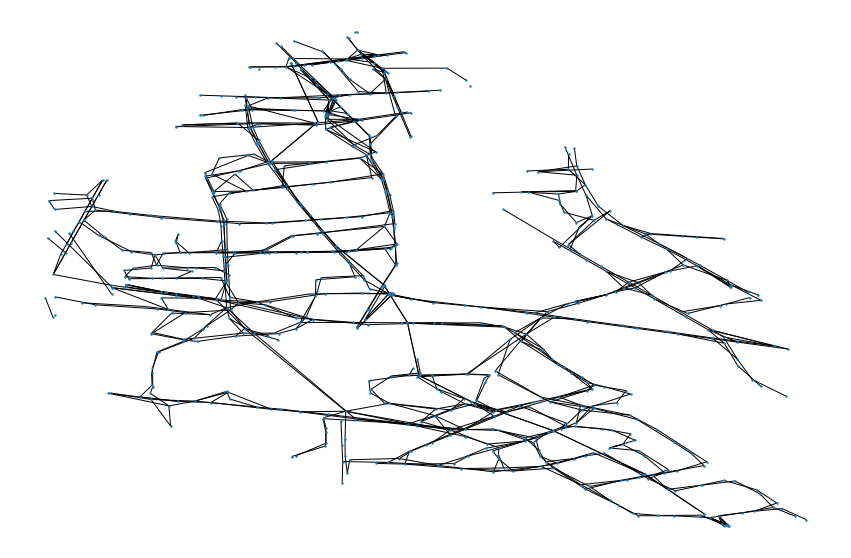

In [5]:
fig, ax = plt.subplots(figsize=(15,10))
nx.draw(nx.subgraph(G, times[20]), pos=points, node_size =2, ax=ax)

<IPython.core.display.Javascript object>


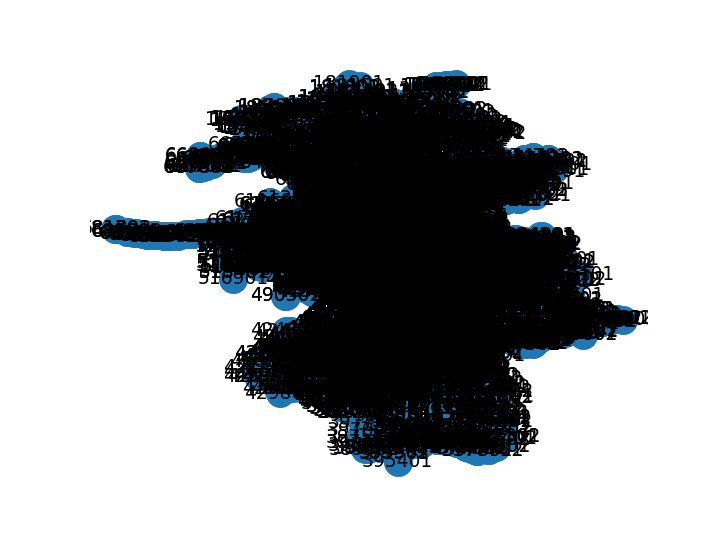

In [27]:
%matplotlib notebook
from copy import copy
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()

def init():
    G_plot = copy(nx.subgraph(G, times[0]))
    G_plot.add_nodes_from(G.nodes)
    nx.draw(nx.subgraph(G_plot, times[0]), pos=points, with_labels=False, ax=ax)
    return ax
    

def update(frame):
    ax.clear()
    G_plot = copy(nx.subgraph(G, times[frame]))
    G_plot.add_nodes_from(G.nodes)
    nx.draw(G_plot, pos=points, with_labels=False, ax=ax)
    ax.set_title(f"Iteration nr. {round(frame*2)}/50")
    return ax

ani = FuncAnimation(fig, update, frames=np.linspace(0, 50), interval=100, init_func=init)

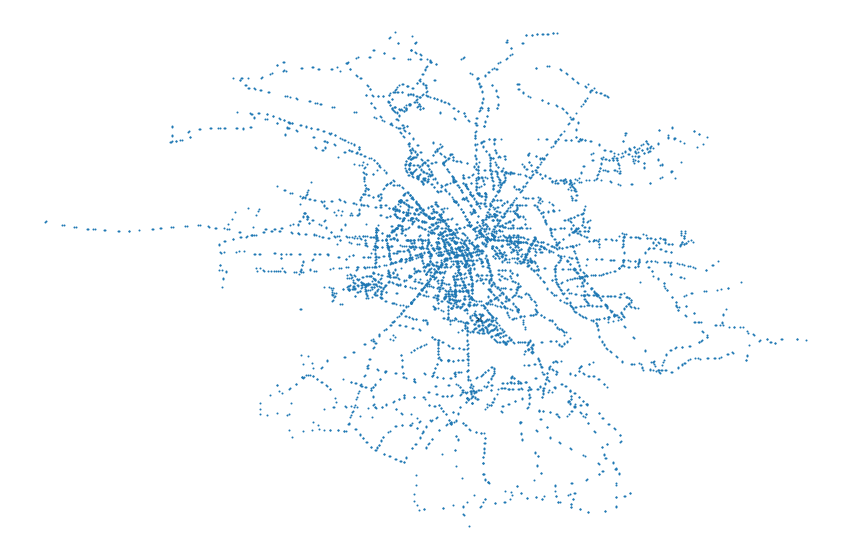

In [9]:
G_plot = nx.Graph()
G_plot.add_nodes_from(G.nodes)
G_plot.add_edges_from( nx.subgraph(G, times[1]).edges)
fig, ax = plt.subplots(figsize=(15,10))
nx.draw(G_plot, pos= points, node_size =1, ax=ax)